# Discrete phase-type distribution of mutations

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

In [2]:
def plot_graph(gam, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    
    states, sim, ipv = np.array(gam[0]), np.array(gam[1]), np.array(gam[2])

    states = np.array(states)
    states = np.append(states, np.array([[9]*states.shape[1]]), axis=0)

    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]
    
    dot = Digraph()
    dot.node('S', 'S')
    dot.node(str(len(states)-1), 'Absorbing')    
    for i in range(0, len(states)-1):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i), constraint=constrained, label=str(ipv[i]))
    for i in range(len(states)):
        for j in range(len(states)):
            if i != j and rates[i, j] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i, j]))
    dot.graph_attr['size'] = size                
    return dot

R header:

In [3]:
%%R
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms", 
                         # force = TRUE
                        )
library(ptdalgorithms)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Indlæser krævet pakke: usethis

R[write to console]: Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (0c1be222) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
# %%R
# pkgbuild::check_build_tools(debug = TRUE)

# State space for continuous version in C

In [5]:
%%R
Rcpp::sourceCpp("./two_locus_two_island.cpp")

ld: warning: -pie being ignored. It is only used when linking a main executable


In [6]:
def plot_graph(gam, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    
    states, sim, ipv = np.array(gam[0]), np.array(gam[1]), np.array(gam[2])

    states = np.array(states)
    states = np.append(states, np.array([[9]*states.shape[1]]), axis=0)

    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]
    
    dot = Digraph()
    dot.node('S', 'S')
    dot.node(str(len(states)-1), 'Absorbing')    
    for i in range(0, len(states)-1):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i), constraint=constrained, label=str(ipv[i]))
    for i in range(len(states)):
        for j in range(len(states)):
            if i != j and rates[i, j] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i, j]))
    dot.graph_attr['size'] = size                
    return dot

In [7]:
%%R -o gam -o s
s <- 4
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 0)
gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6


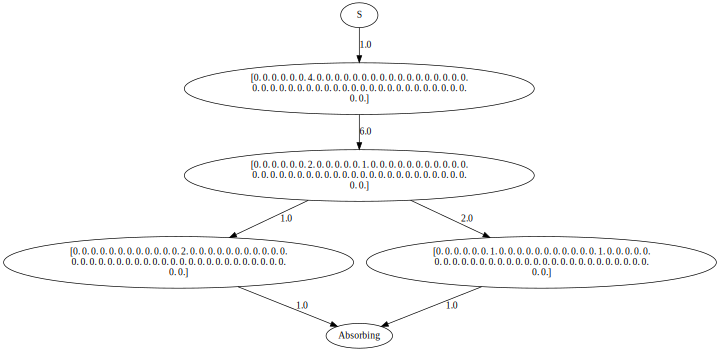

In [8]:
plot_graph(gam)

# Turn into discrete version

In [9]:
%%R -o gam -o rewards

make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# self-transition rate:
mutation_rate <- 1

# clone graph to get one to modify:
mutation_graph <- clone_graph(graph)

# add auxilliary states, normalize and return reward matrix:
rewards <- make_discrete(mutation_graph, mutation_rate)

# for plotting the new graph
gam <- graph_as_matrix(mutation_graph)

vertices_length(mutation_graph)

[1] 12


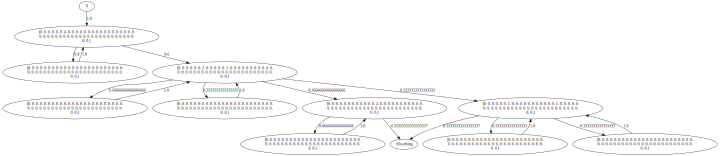

In [10]:
plot_graph(gam)

# Sanity checks

In [11]:
%%R
expectation(mutation_graph, colSums(rewards))

[1] 3.666667


INFO: building reward compute graph...


In [12]:
%%R

broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

disc_two_locus_expectation <- function(s, N1, N2, M1, M2, R) 
{
    graph <- construct_twolocus_island_graph(s, N1, N2, M1, M2, R)

    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, 1)
    
    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(mutation_graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

disc_ton_covariance_between_loci <- function(s, N1, N2, M1, M2, R) 
{
    graph <- construct_twolocus_island_graph(s, N1, N2, M1, M2, R)

    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, 1)
    
    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
} 

In [13]:
%%R -o disc_cov_mat_no_rec_no_mig
disc_cov_mat_no_rec_no_mig <- disc_ton_covariance_between_loci(4, 1, 1, 0.5, 0.5, 2) 

INFO: building reward compute graph...


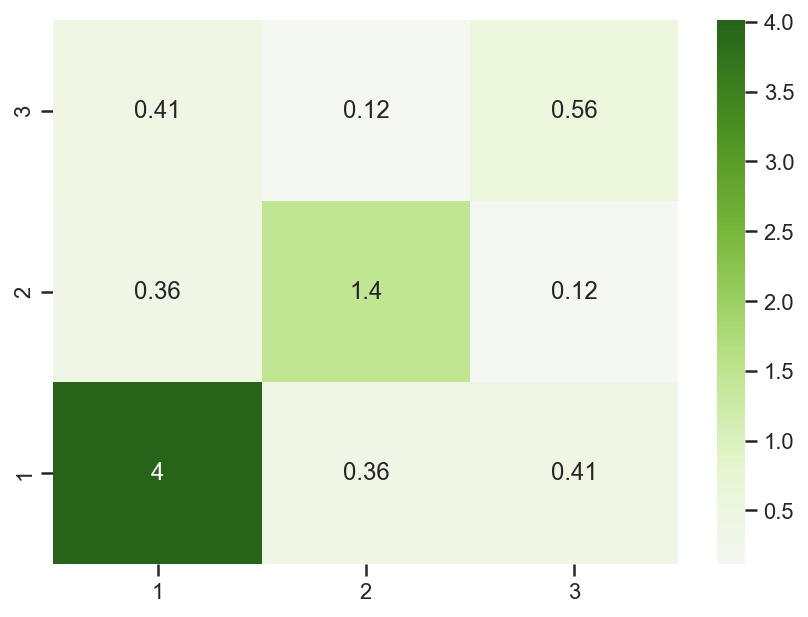

In [14]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(disc_cov_mat_no_rec_no_mig, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

Compare to continuous:

In [15]:
%%R -o cov_mat_no_rec_no_mig

broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_between_loci <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
} 

cov_mat_no_rec_no_mig <- ton_covariance_between_loci(4, 1, 0.5, 1) 

INFO: building reward compute graph...


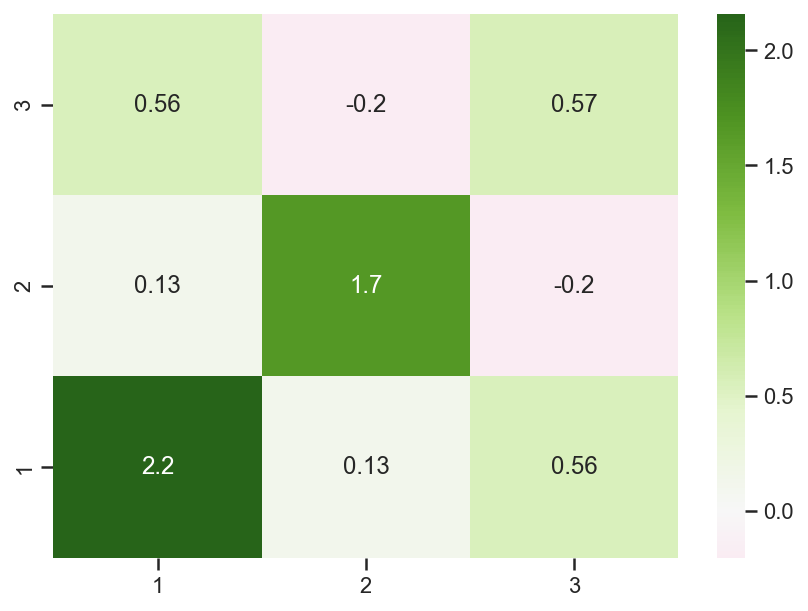

In [16]:
plt.subplots(1, 1, figsize=(7, 5))
ticks = list(range(1,int(s)))
ax = sns.heatmap(cov_mat_no_rec_no_mig, cmap="PiYG", 
                annot=True,
                center=0,
                yticklabels=ticks,
                xticklabels=ticks
                )
ax.invert_yaxis()

In [104]:
%%R -o n -o m -o fit_mat_exp -o fit_mat_cov -o fit_mat

library(parallel)

apply_grid <- function(fun, a, b) {
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fun, as.list(as.vector(unlist(x)))), mc.cores=4L)
    fit_mat <- array(unlist(result_list), dim = c(2, length(a),length(b)))
    # fit_mat <- matrix(, nrow=length(a),ncol=length(b))
    return(fit_mat)
}

s <- 4
expected_cov_mat <- disc_ton_covariance_between_loci(s, 1, 1, 0.5, 0.5, 1)
expected_exp_mat <- disc_two_locus_expectation(s, 1, 1, 0.5, 0.5, 1)


fit <- function(N, M) {
    observed_cov_mat <- disc_ton_covariance_between_loci(s, N, N, M, M, 1)
    observed_exp_mat <- disc_two_locus_expectation(s, N, N, M, M, 1)
    
    cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
    exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(c(exp_fit, cov_fit))
}
n <- seq(0.5, 2.5, 0.05)
m <- seq(0.01, 2.01, 0.05)
fit_mat <- apply_grid(fit, n, m)

fit_mat_exp <- fit_mat[1,,]
fit_mat_cov <- fit_mat[2,,]
fit_mat <- fit_mat_exp + fit_mat_cov
fit_mat

INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

           [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
 [1,] 24.325413 16.227231 15.252027 14.725992 14.332384 13.998823 13.700018
 [2,] 19.791857 15.129329 14.416629 13.956931 13.575257 13.232030 12.913636
 [3,] 15.385941 13.963646 13.493099 13.090923 12.715966 12.359586 12.019162
 [4,] 11.137596 12.739303 12.489275 12.135771 11.762614 11.390016 11.025586
 [5,]  7.734346 11.463237 11.411989 11.098677 10.722882 10.331498  9.941569
 [6,]  8.972990 10.140886 10.267329  9.986341  9.604037  9.191816  8.775366
 [7,] 10.024255  8.776656  9.060803  8.805020  8.412938  7.978341  7.534786
 [8,] 10.896774  7.374225  7.797464  7.560573  7.156044  6.698010  6.227162
 [9,] 11.601130  5.936755  6.481980  6.258490  5.839418  5.357328  4.859350
[10,] 12.148840  4.467033  5.118695  4.903915  4.468741  3.962371  3.437727
[11,] 13.862690  4.006688  4.516162  4.114569  3.508011  2.853581  2.203196
[12,] 16.835852  5.125225  5.671146  5.239207  4.591231  3.895325  3.206396
[13,] 19.688

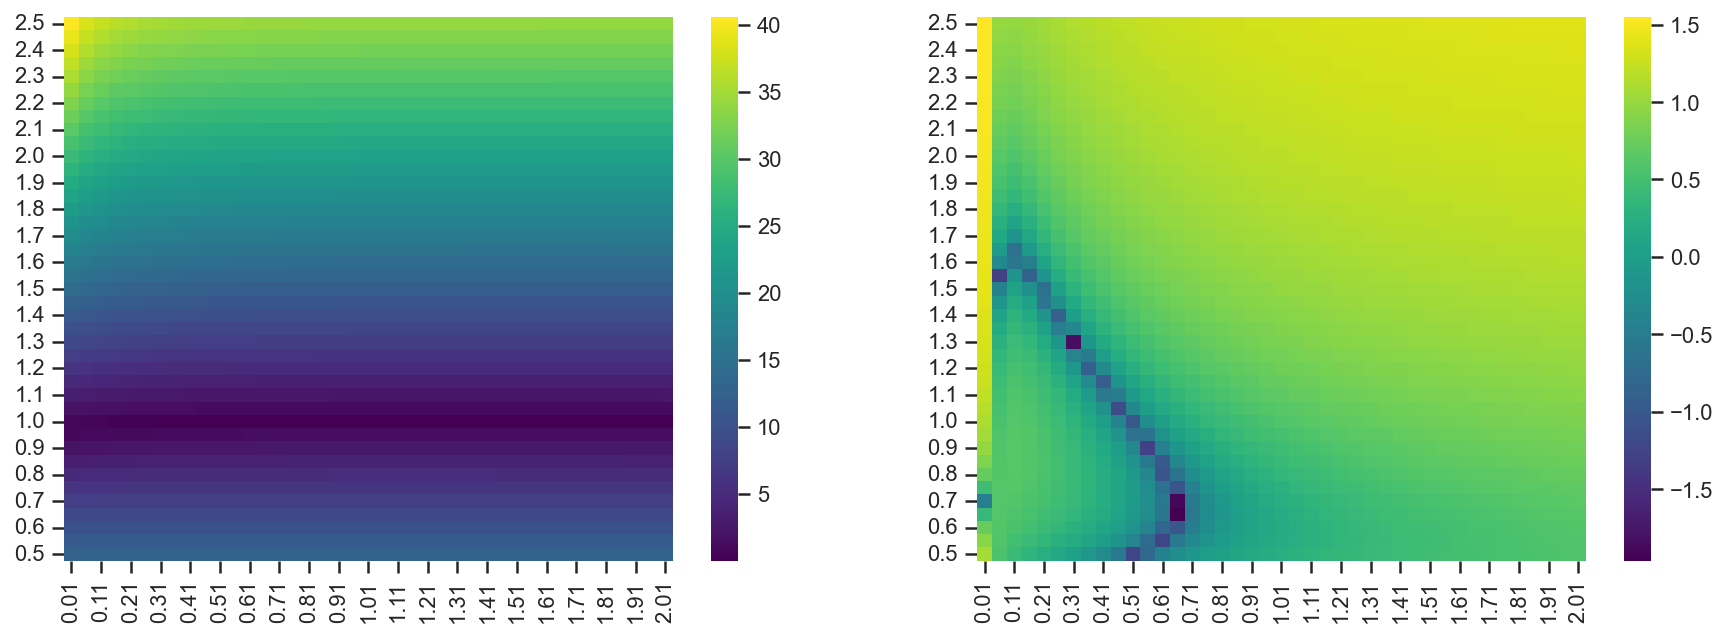

In [105]:
plot_df = pd.DataFrame(fit_mat_exp, columns=np.round(m, 2), index=np.round(n, 2))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
g = sns.heatmap(plot_df, cmap="viridis", ax=ax1)
ax1.invert_yaxis()
plot_df = pd.DataFrame(fit_mat_cov, columns=np.round(m, 2), index=np.round(n, 2))
g = sns.heatmap(np.log10(plot_df), cmap="viridis", ax=ax2)
ax2.invert_yaxis()
plt.savefig('fit2.pdf', bbox_inches='tight')

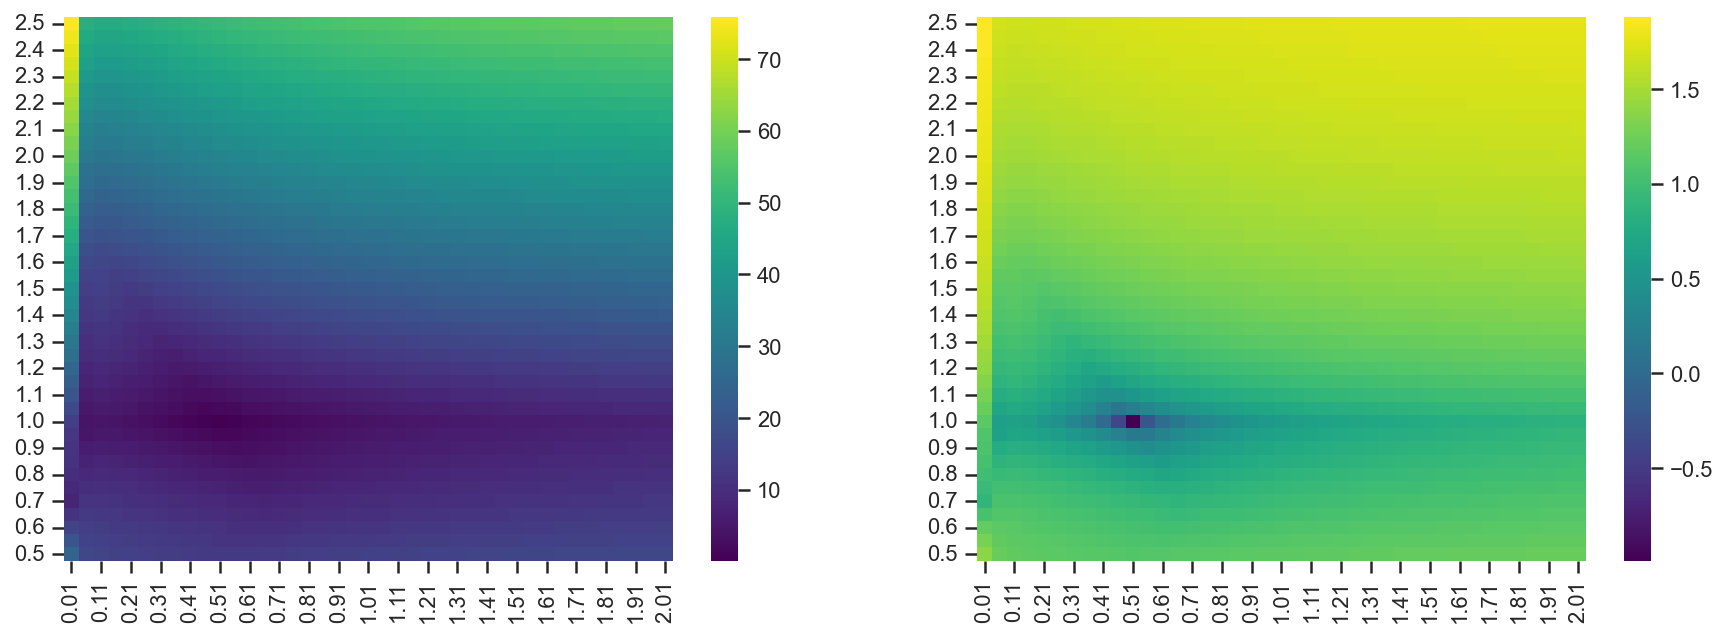

In [106]:
plot_df = pd.DataFrame(fit_mat, columns=np.round(m, 2), index=np.round(n, 2))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
g = sns.heatmap(plot_df, cmap="viridis", ax=ax1)
ax1.invert_yaxis()
plot_df.where(plot_df <= 0, np.nan)
g = sns.heatmap(np.log10(plot_df), cmap="viridis", ax=ax2)
ax2.invert_yaxis()
plt.savefig('fit2.pdf', bbox_inches='tight')

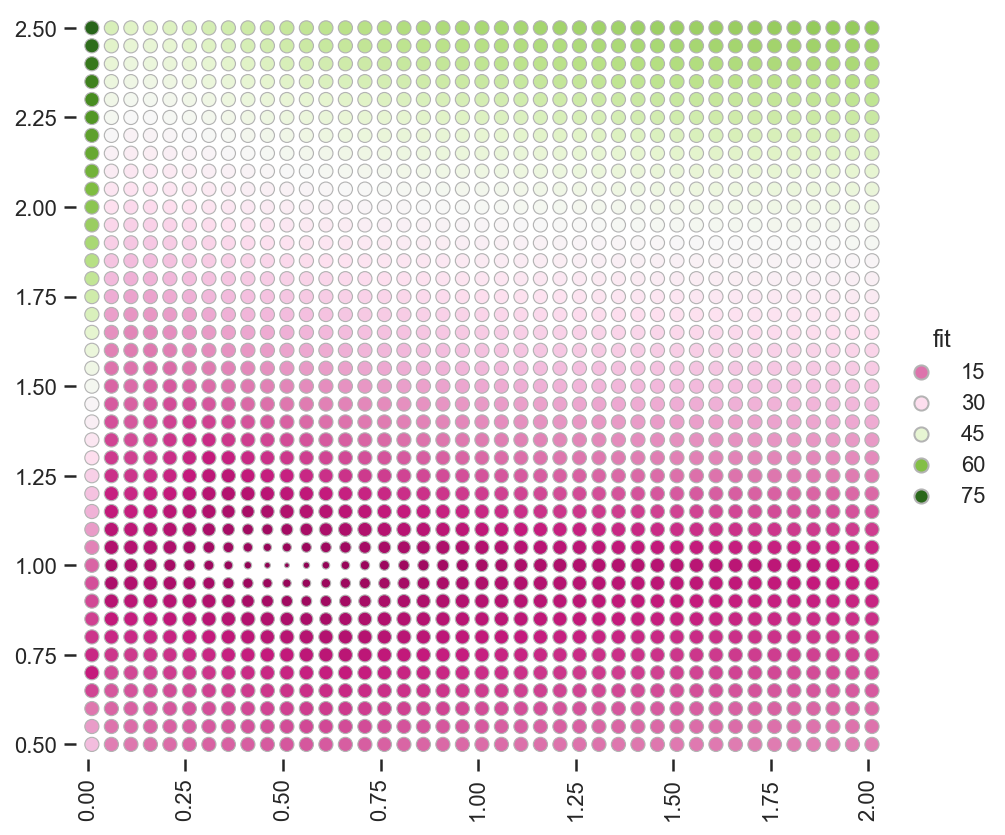

In [19]:
plot_df = pd.DataFrame(fit_mat, columns=m, index=n).stack().reset_index(name="fit")

g = sns.relplot(
    data=plot_df,
    x="level_1", y="level_0", hue="fit", size="fit",
    palette="PiYG", #hue_norm=(-1, 1), 
    # palette="vlag", #hue_norm=(-1, 1),     
    edgecolor=".7",
    height=6, aspect=1.1,
    sizes=(5, 50), 
    size_norm=(0, 5),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [34]:
# %%R -o fit_mat -o n -o m
# s <- 4

# n <- seq(0.5, 2.5, 0.05)
# m <- seq(0.001, 0.021, 0.0005)
# fit_mat <- apply_grid(fit, n, m)

In [33]:
# plot_df = pd.DataFrame(fit_mat, columns=m, index=n).stack().reset_index(name="fit")

# g = sns.relplot(
#     data=plot_df,
#     x="level_1", y="level_0", hue="fit", size="fit",
#     palette="vlag", #hue_norm=(-1, 1), 
#     edgecolor=".7",
#     # height=10, 
#     # sizes=(20, 200), 
#     height=6, aspect=1.1,
#     sizes=(5, 50),     
#     size_norm=(0, 10), 
# )

# # Tweak the figure to finalize
# g.set(xlabel="M", ylabel="N")
# g.despine(left=True, bottom=True)
# g.ax.margins(.02)
# for label in g.ax.get_xticklabels():
#     label.set_rotation(90)
# for artist in g.legend.legendHandles:
#     artist.set_edgecolor(".7")

# Fit parameters to expectations and covariance

Assuming empirical SFS is perfectly known.

## Standard optim

In [ ]:
# %%R
# library(stats)

# s <- 4
# # fake empirical observation
# expected_cov_mat <- disc_ton_covariance_between_loci(s, 1, 1, 0.5, 0.5, 1)
# expected_exp_mat <- disc_two_locus_expectation(s, 1, 1, 0.5, 0.5, 1)

# fit <- function(x) {
#     N1 <- x[1]
#     M1 <- x[2]
#     N2 <- N1
#     M2 <- M1
#     # N1 <- x[1]
#     # N2 <- x[2]
#     # M1 <- x[3]
#     # M2 <- x[4]
#     observed_cov_mat <- disc_ton_covariance_between_loci(s, N1, N2, M1, M2, 0.5)
#     observed_exp_mat <- disc_two_locus_expectation(s, N1, N2, M1, M2, 0.5)
#     cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
#     exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
#     return(exp_fit + cov_fit)
# }

# outoptim <- optim(c(2, 0.01), fit)
# #outoptim <- optim(c(2, 2, 0.01, 0.01), fit)

In [ ]:
# %%R
# outoptim

## Differential evolution

In [110]:
%%R -o fit -o expected_cov_mat -o expected_exp_mat
library(parallel)
library(foreach)
library(DEoptim)

s <- 4
# fake empirical observation
expected_cov_mat <- disc_ton_covariance_between_loci(s, 1, 1, 0.5, 0.5, 1)
expected_exp_mat <- disc_two_locus_expectation(s, 1, 1, 0.5, 0.5, 1)

fit <- function(x) {
    N1 <- x[1]
    M1 <- x[2]
    N2 <- N1
    M2 <- M1
    observed_cov_mat <- disc_ton_covariance_between_loci(s, N1, N2, M1, M2, 1)
    observed_exp_mat <- disc_two_locus_expectation(s, N1, N2, M1, M2, 1)
    cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
    exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(exp_fit + cov_fit)
}

controls = DEoptim.control(#itermax = 400,
                           #NP=20, 
                            strategy=1,
                          #storepopfrom = 1, storepopfreq = 1, 
                        parallelType=2)
#outDEoptim <- DEoptim(fit, c(0.5, 0.1), c(1.5, 1.1), controls)
outDEoptim <- DEoptim(fit, c(0.5, 0), c(5, 1), controls)
#outDEoptim <- DEoptim(fit, c(0.5, 0.5, 0.1, 0.1), c(1.5, 1.5, 1.1, 1.1), controls)



INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 1 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 2 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 3 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 4 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 5 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 6 bestvalit: 1.082253 bestmemit:    1.031994    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 7 bestvalit: 0.884760 bestmemit:    1.009417    0.434233


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 8 bestvalit: 0.884760 bestmemit:    1.009417    0.434233


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 9 bestvalit: 0.795692 bestmemit:    0.974801    0.499448


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 10 bestvalit: 0.795692 bestmemit:    0.974801    0.499448


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 11 bestvalit: 0.795692 bestmemit:    0.974801    0.499448


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 12 bestvalit: 0.795692 bestmemit:    0.974801    0.499448


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 13 bestvalit: 0.688268 bestmemit:    1.001785    0.569089


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 14 bestvalit: 0.688268 bestmemit:    1.001785    0.569089


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 15 bestvalit: 0.502124 bestmemit:    1.000514    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 16 bestvalit: 0.502124 bestmemit:    1.000514    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 17 bestvalit: 0.502124 bestmemit:    1.000514    0.453612


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 18 bestvalit: 0.052214 bestmemit:    1.000514    0.495856


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 19 bestvalit: 0.052214 bestmemit:    1.000514    0.495856


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 20 bestvalit: 0.052214 bestmemit:    1.000514    0.495856


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 21 bestvalit: 0.052214 bestmemit:    1.000514    0.495856


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 22 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 23 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 24 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 25 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 26 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 27 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 28 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 29 bestvalit: 0.036241 bestmemit:    0.999010    0.501764


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 30 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 31 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 32 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 33 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 34 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 35 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 36 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 37 bestvalit: 0.005484 bestmemit:    1.000202    0.499825


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 38 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 39 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 40 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 41 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 42 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 43 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 44 bestvalit: 0.002601 bestmemit:    1.000023    0.499787


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 45 bestvalit: 0.001073 bestmemit:    0.999962    0.500037


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 46 bestvalit: 0.000923 bestmemit:    1.000029    0.499962


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 47 bestvalit: 0.000923 bestmemit:    1.000029    0.499962


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 48 bestvalit: 0.000923 bestmemit:    1.000029    0.499962


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 49 bestvalit: 0.000677 bestmemit:    1.000006    0.500053


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 50 bestvalit: 0.000596 bestmemit:    1.000020    0.499977


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 51 bestvalit: 0.000234 bestmemit:    1.000007    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 52 bestvalit: 0.000234 bestmemit:    1.000007    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 53 bestvalit: 0.000234 bestmemit:    1.000007    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 54 bestvalit: 0.000232 bestmemit:    1.000006    0.500003


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 55 bestvalit: 0.000232 bestmemit:    1.000006    0.500003


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 56 bestvalit: 0.000232 bestmemit:    1.000006    0.500003


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 57 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 58 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 59 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 60 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 61 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 62 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 63 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 64 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 65 bestvalit: 0.000037 bestmemit:    0.999999    0.500002


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 66 bestvalit: 0.000023 bestmemit:    1.000000    0.499998


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 67 bestvalit: 0.000007 bestmemit:    1.000000    0.500001


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 68 bestvalit: 0.000007 bestmemit:    1.000000    0.500001


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 69 bestvalit: 0.000007 bestmemit:    1.000000    0.500001


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 70 bestvalit: 0.000007 bestmemit:    1.000000    0.500001


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 71 bestvalit: 0.000007 bestmemit:    1.000000    0.500001


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 72 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 73 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 74 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 75 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 76 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 77 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 78 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 79 bestvalit: 0.000005 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 80 bestvalit: 0.000002 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 81 bestvalit: 0.000002 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 82 bestvalit: 0.000002 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 83 bestvalit: 0.000001 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 84 bestvalit: 0.000001 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 85 bestvalit: 0.000001 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 86 bestvalit: 0.000001 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 87 bestvalit: 0.000001 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 88 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 89 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 90 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 91 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 92 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 93 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 94 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 95 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 96 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 97 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 98 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 99 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 100 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 101 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 102 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 103 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 104 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 105 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 106 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 107 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 108 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 109 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 110 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 111 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 112 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 113 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 114 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 115 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 116 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 117 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 118 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 119 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 120 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 121 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 122 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 123 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 124 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 125 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 126 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 127 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 128 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 129 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 130 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 131 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 132 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 133 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 134 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 135 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 136 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 137 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 138 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 139 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 140 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 141 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 142 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 143 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 144 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 145 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 146 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 147 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 148 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 149 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 150 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 151 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 152 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 153 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 154 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 155 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 156 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 157 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 158 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 159 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 160 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 161 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 162 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 163 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 164 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 165 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 166 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 167 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 168 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 169 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 170 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 171 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 172 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 173 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 174 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 175 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 176 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 177 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 178 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 179 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 180 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 181 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 182 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 183 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 184 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 185 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 186 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 187 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 188 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 189 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 190 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 191 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 192 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 193 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 194 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 195 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 196 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 197 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 198 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 199 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward com

Iteration: 200 bestvalit: 0.000000 bestmemit:    1.000000    0.500000


INFO: building reward compute graph...


## Notes
Only a single N and M can be estimated. Using rec of 0.5 seems to work.

In [111]:
%%R
summary(outDEoptim)


***** summary of DEoptim object ***** 
best member   :  1 0.5 
best value    :  0 
after         :  200 generations 
fn evaluated  :  402 times 
*************************************


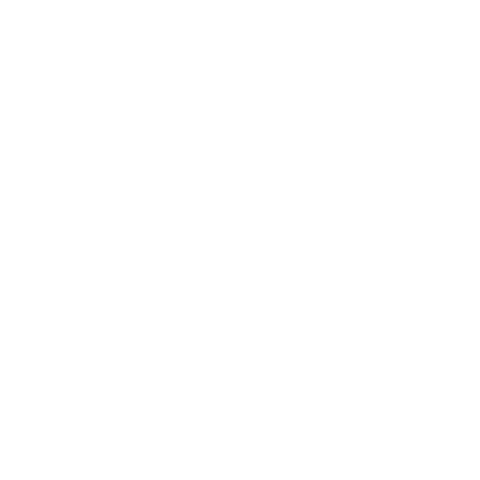

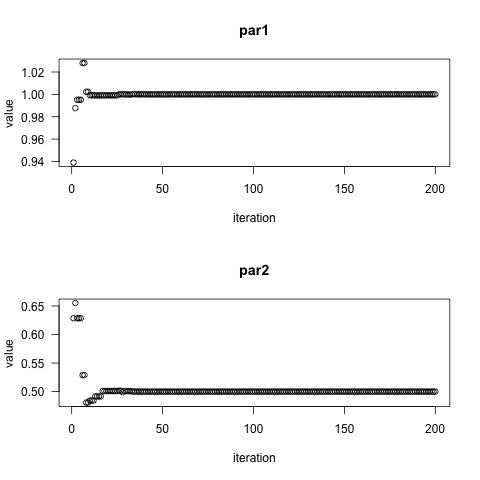

In [27]:
%%R
plot(outDEoptim, plot.type="bestmemit")

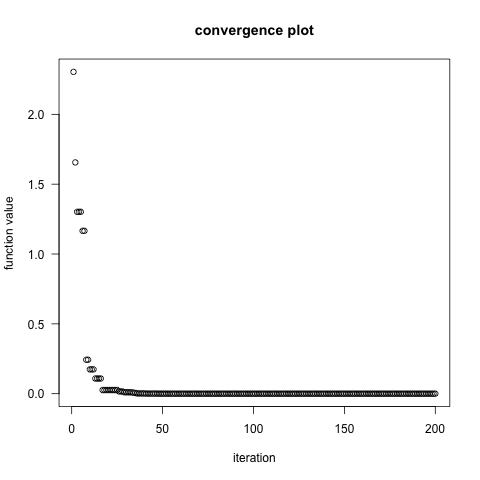

In [28]:
%%R
plot(outDEoptim, plot.type="bestvalit")

In [29]:
%%R
plot(outDEoptim, plot.type="storepop",  type = 'b')

R[write to console]: Advarsel i plot.DEoptim(outDEoptim, plot.type = "storepop", type = "b") :
R[write to console]: 
 
R[write to console]:  'plot.type' does not correspond to any plotting type

